## Tests for unsupervised document similarity for ranking in online health communities

In [15]:
from io import open
import json
import random 
from time import time
from collections import Counter

import numpy as np
import numpy.random as npr
import scipy.stats as st
import scipy.special as sp
import pandas as pd
import itertools
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set_color_codes()

## What does the data look like?

#### train_data.json

* _(list)_ of discussions
    * _(str)_ `category` -- freetext category of a discussion
    * _(str)_ `heading` -- freetext heading of a discussion
    * _(list)_ `posts` -- all of the posts in the discussion
        * _(int)_ `uid` -- id of post in discussion. Zero is original post. Unique within a discussion
        * _(int)_ `parent_uid` -- id of the post that this post is in reply to. Root post has itself as the parent
        * _(str)_ `user` -- freetext user name for the author of the post
        * _(int)_ `timestamp` -- normalized unix timestamp of the post 
        * _(str)_ `text` -- freetext of the post, not tokenized
            
**NOTE:** Some posts are missing any of category, user, or timestamp, these have been given default values

#### test_data.json

* _(list)_ of discussions
    * _(list)_ `posts` -- all of the posts in a discussion
        * _(int)_ `uid` -- id of post, unique within discussion
        * _(str)_ `text` -- freetext of the post
    * _(list)_ `relevance_scores` -- list of triples of (anchor post id, candidate post id, relevance score)

In [16]:
train_data = json.load(open('train_data.json'))
test_data = json.load(open('test_data.json'))

In [17]:
print "Training Data"
a = np.array([len(d['posts']) for d in train_data])
print "{0} discussions, {1} posts total, \n{2:2.2f} avg posts/discussion with {3:2.2f} std deviation".format(
    len(train_data), a.sum(), a.mean(), a.std())

print "\nTest Data"
a = np.array([len(d['posts']) for d in test_data])
print "{0} discussions, {1} posts total, \n{2:2.2f} avg posts/discussion with {3:2.2f} std deviation".format(
    len(train_data), a.sum(), a.mean(), a.std())

Training Data
20404 discussions, 296118 posts total, 
14.51 avg posts/discussion with 45.27 std deviation

Test Data
20404 discussions, 122 posts total, 
40.67 avg posts/discussion with 6.55 std deviation


In [32]:
train_post_texts = [ post['text'] for discussion in train_data for post in discussion['posts'] ]
test_post_texts = [ post['text'] for discussion in test_data for post in discussion['posts'] ]
all_post_texts = train_post_texts + test_post_texts

## Experiments

The experiment template is as follows: Train some pipeline on a bunch of unlabeled data (raw train + test posts), then use similarity metrics to provide a ranking of a set of documents (all posts within a discussion) to a query document (the anchor post). This ranking will be compared to a gold ranking.

The test metric is [nDCG](https://en.wikipedia.org/wiki/Discounted_cumulative_gain). Discounted cumulative gain is a measure of ranking quality that weighs the top of the ranking list more than lower down the list. Normalized DCG is when you compute DCG score on a gold ranking of documents as the _idealized DCG_ and then divide test DCG by this.

**We measure the nDCG@top-k where k $\in \{5,10,15\}$**

Additionally we want confidence intervals for the nDCG for each method for each k. 

**We get confidence intervals by doing a bootstrap empircal 95% confidence interval**

This is a little tricky, since our data lie in 9 subgroups (3 anchors for each of the 3 discussions).

We calculate bootstrap statistics for the average nDCG across the 9 subgroups as follows:

Call the nDCGs for each subgroup $x_1, ..., x_9$ and the data average nDCG $\bar{x} = \frac{1}{9}\sum\limits_{i=1}^9{x_i}$.  

To get a bootstrap estimate for this, we must resample these data, by resampling the data for each subgroup and calculating the nDCG for each resample (across the 9 groups).  

Call these $x_1^{*(j)}, ...,  x_9^{*(j)} \text{ for } j\in \{1,...,B\}$ and the average nDCG _for a single resample j_, $\bar{x}^{*(j)}$. 

Then we can compute confidence intervals around $\bar{x}$ the usual way by finding the $\alpha=.025$ boundary quantiles $\delta_{\alpha}, \delta_{1-\alpha}$, such that 

$$P(\bar{x}^* - \delta_{1-\alpha} \leq \bar{x} \leq \bar{x}^* - \delta_{\alpha}) = .95$$

In [19]:
from ranking_metrics import ndcg_score

In [401]:
def bootstrap_score(trues, preds, scoring_func, B=10000, **scoring_func_kwds):
    """ Compute a bootstrapped estimate of the model score. 
    
    An intuitive and practical guide to bootstrap estimation:
    https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf
    """
    samples = []
    idxs = np.arange(len(trues))
    for i in range(B):
        sample = npr.choice(idxs, len(idxs))
        samples.append(scoring_func(trues[sample], preds[sample], **scoring_func_kwds))
    return samples

def score_model_at_k(model, k, data=test_data, 
                     verbose=0, B=10000,
                     refit_per_discussion=False):
    """ Take some model, get relevance scores from it on test data, return nDCG at specified k"""
    if verbose: print 'k={}'.format(k), '-'*50
    all_scores = []
    for i, discussion in enumerate(data):
        if refit_per_discussion:
            model.fit([post['text'] for post in discussion['posts']])
        scores = {}
        for anchor_id, candidate_id, true_score in discussion['relevance_scores']:
            # organize true relevance scores grouped by anchor post
            if anchor_id in scores:
                scores[anchor_id]['trues'].append(true_score)
            else:
                scores[anchor_id] = {'trues':[true_score], 'preds':[]}
            
            pred_score = model.predict(discussion['posts'][anchor_id]['text'],
                                       discussion['posts'][candidate_id]['text'])
#             print pred_score
            scores[anchor_id]['preds'].append(pred_score)
            if verbose > 1: print true_score, pred_score
        for anchor_id in scores:
            trues = np.array(scores[anchor_id]['trues'])
            preds = np.array(scores[anchor_id]['preds'])
            ndcg = ndcg_score(trues, preds, k=k)
            if B:
                ndcg_bootstrapped = bootstrap_score(trues, preds, ndcg_score, B=B, k=k)
                # the true ndcg will just be the first one, all the rest are resampled
                all_scores.append([ndcg] + ndcg_bootstrapped)
            else:
                all_scores.append(ndcg)
            if verbose: print 'Discussion {0} ndcg for anchor {1} = {ndcg:2.2f}'.format(i, anchor_id,
                                                                                        ndcg=ndcg)
    return all_scores
        
def score_model(model, model_name, ks=[5,10,15], B=10000, **kwds):
    """ Run the entire experiment for some pretrained model. """
    results = {}
    fig, axs = plt.subplots(1,len(ks),figsize=(3*len(ks),3))
    for i, k in enumerate(ks):
        # do scoring
        all_scores = score_model_at_k(model, k, B=B, **kwds)
        ndcgs = [ scores[0] for scores in all_scores]
        ndcgs_resampled = zip(*[bootstrap_sample[1:] for bootstrap_sample in all_scores])
        ndcg_mean, resampled_means = np.mean(ndcgs), [np.mean(sample) for sample in ndcgs_resampled]
        diffs = [resampled_mean - ndcg_mean for resampled_mean in resampled_means]
#         variance = 
        alpha = .025
        ci_bottom = ndcg_mean - np.percentile(diffs, 100.*(1-alpha))
        ci_top = ndcg_mean - np.percentile(diffs, 100.*alpha)
        results[k] = {
            'mean':ndcg_mean,
            'ci':(ci_bottom, ci_top),
            'scores':[ score for scores in all_scores for score in scores ]
        }
#         print "nDCG@{k}: mean={mean:2.2f}, std={std:2.2f}".format(k=k, mean=mean, std=std)

        # make nice plots
        flat_ndcgs = [ ndcg for sample in all_scores for ndcg in sample ]
        axs[i].hist(flat_ndcgs, bins=.1*np.arange(11))
        axs[i].axvline(ndcg_mean, color='red')
        axs[i].axvspan(ci_bottom, ci_top, alpha=.25, color='red')
        axs[i].set_xlim((-.05, 1.05))
        axs[i].set_title("nDCG@{k} Histogram".format(k=k))
        axs[i].set_xlabel("nDCG: mean={mean:2.2f}, \n95% CI = ({ci_bottom:2.2f}, {ci_top:2.2f})".format(
                mean=ndcg_mean, ci_bottom=ci_bottom, ci_top=ci_top))
        if i == 0:
            axs[i].set_ylabel("Bin Count")
    fig.suptitle("Bootstrapped nDCG for {} (B={})".format(model_name, B), fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.8)
    results['fig'] = fig
    return results

In [21]:
def error_analyze(model, model_name, ks=[5,10,15], **kwds):
    """ The a pretrained model on the test data, and determine which documents and which discussions it failed on. """
    fig, axs = plt.subplots(1,len(ks),figsize=(3*len(ks),3))
    results = {}
    for i, k in enumerate(ks):
        all_scores = score_model_at_k(model, k, B=0)
#         print k, all_scores
        results[k] = all_scores
        axs[i].stem(range(len(all_scores)), all_scores)
        axs[i].set_title("nDCG@{k} for each test ranking".format(k=k))
        axs[i].set_xlim((-1, len(all_scores)))
        axs[i].set_ylim((0., 1.1))
        axs[i].set_xticks(range(len(all_scores)))
        axs[i].set_xticklabels(range(len(all_scores)))
        if i == 0:
            axs[i].set_ylabel("nDCG Score")
        if i == len(ks)/2:
            axs[i].set_xlabel("Test Discussion Trials")
    fig.suptitle("nDCG for {}".format(model_name), fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.8)
    return results

In [22]:
results = {}

## Models

### Baselines

1. Random similarity scores
2. TF-IDF
3. LSA on token-doc matrix (How do topic models deal with short docs?)
4. LDA on union of train and test docs. Score is inner product of topic vectors
5. SF-IDF ([paper](https://link.springer.com/chapter/10.1007/978-3-319-07692-8_35))

### Our Models

#### Neural Continuous Bag of Words (CBOW):

We compute document vectors by aggregating dense vector representations of each word, where each vector for a word represents its meaning. This is essentially what SF-IDF was trying to do, but we do it without any reliance on lexicons, knowledge bases, or semantic supervision. Instead use the [GloVe](https://nlp.stanford.edu/projects/glove/) pretrained 300 dimensional vectors from the common crawl.  These vectors model word meaning well and have been trained on the entire internet (42 billion tokens)

** Aggregation Functions:**
1. Mean of all word vectors (omitting stop words) in the document
2. Sum of all word vectors (omitting stop words) in the document
3. TF-IDF weighted sum of all word vectors (omitting stop words) in the document

#### Possible Way Cooler Models
    
There are a few fancy things we could do:
* Think of the document as a gaussian nonparametric mixture over the pretrained word vectors, fit a CRP to it and then compute the similarity using the integral inner product of the two mixtures (which is easy to compute)
    * Tried this, failed due to numerical issues with data covariance that I couldn't fix after 2 hours, so I gave up.
* Document modeling using a variational autoencoder (like NVDM)
    * Implementing this, but instead of NVDM, we'll treat the word vectors as the input and output data, with losses being the 
* Improve it by using tunable pretrained word embeddings and typing embedding params for discriminator and generator
* Do Neural Gaussian LDA, where the word embeddings are generated from mixture of topic gaussians
* Introduce a third level of grouping that does a discussion-specific prior on the topics

** Neural Variational Gaussian Document Model **

We can do document modeling using a generative model that allows the incorporation of apriori known word similarities through the use of fixed word vectors.

Our generative process is _very_ simple:

1. Sample a latent document representation $z_d \sim \mathcal{N}(\mu, \Sigma^{-1})$
2. For each word $w_i$ in the document with $D$ words:
    1. Sample the word vector $v_{w_i} \sim \mathcal{N}(\mu_{\theta}(z), \Sigma_{\theta}^{-1}(z))$
    


In [294]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation as LDA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.mixture import BayesianGaussianMixture as GMM

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
stop_vocab = set(stopwords.words('english'))
from string import punctuation
from nltk.wsd import lesk


In [24]:
class ModelBase(object):
    def fit(self, training_docs_list, **kwds):
        start = time()
        self.pipeline.fit(training_docs_list, **kwds)
        return time() - start
    
    def predict(self, doc1, doc2):
        vecs = self.pipeline.transform([doc1, doc2])
        sim = cosine_similarity(vecs)
        return sim[0,1]
    
def sec2hms(sec):
    """ Convert seconds to hours:minutes:seconds string """
    m, s = divmod(sec, 60)
    h, m = divmod(m, 60)
    return "{0:02d}:{1:02d}:{2:02d}".format(int(h),int(m),int(s))


### Baseline 1: Random similarity scores

In [25]:
class RandomModel(object):
    def predict(self, doc1, doc2):
        return random.random()

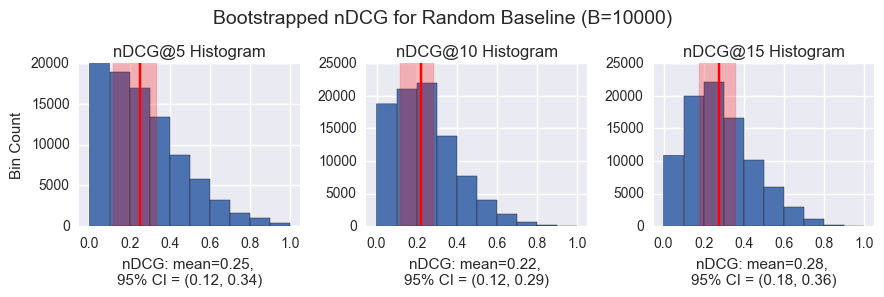

In [26]:
random_model = RandomModel()
model_name = "Random Baseline"
results[model_name] = score_model(random_model, model_name, B=10000, verbose=0)

### Baseline 2: TF-IDF Cosine

In [53]:
class TfIdfModel(ModelBase):
    def __init__(self):
        self.tokenizer = TweetTokenizer()
        self.tokenize = self.tokenizer.tokenize
        self.pipeline = TfidfVectorizer(min_df=5, stop_words='english', tokenizer=self.tokenize)

Training... Took 00:01:49 hours for 296240 docs


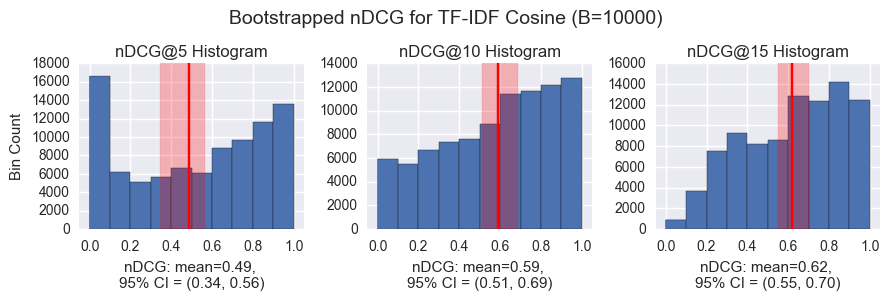

In [54]:
tfidf_model = TfIdfModel()
print "Training...",
train_time = tfidf_model.fit(all_post_texts)
print "Took {} hours for {} docs".format(sec2hms(train_time), len(all_post_texts))
model_name = "TF-IDF Cosine"
results[model_name] = score_model(tfidf_model, model_name, B=10000, verbose=0)

Training... Took 00:01:50 hours for 296240 docs


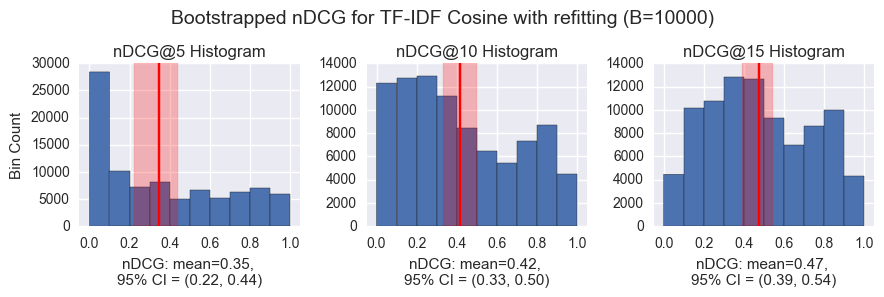

In [26]:
tfidf_model = TfIdfModel()
print "Training...",
train_time = tfidf_model.fit(all_post_texts)
print "Took {} hours for {} docs".format(sec2hms(train_time), len(all_post_texts))
model_name = "TF-IDF Cosine with refitting"
results[model_name] = score_model(tfidf_model, model_name, B=10000, verbose=0, refit_per_discussion=True)

### Baseline 3: LSA

In [27]:
class LSAModel(ModelBase):
    def __init__(self, n_latent):
        self.tokenizer = TweetTokenizer()
        self.tokenize = self.tokenizer.tokenize
        self.vectorizer = CountVectorizer(min_df=5, stop_words='english', tokenizer=self.tokenize)
        self.lsa = TruncatedSVD(n_latent, random_state=0)
        self.pipeline = Pipeline([('vec', self.vectorizer), ('lsa', self.lsa)])

Training... Took 00:01:50 hours for 296240 docs
Training... Took 00:01:55 hours for 296240 docs
Training... Took 00:02:13 hours for 296240 docs


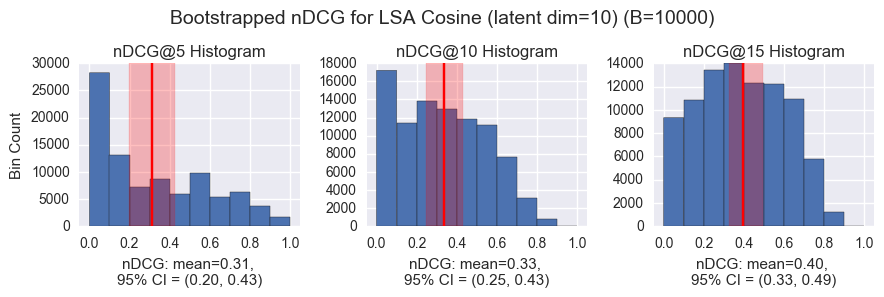

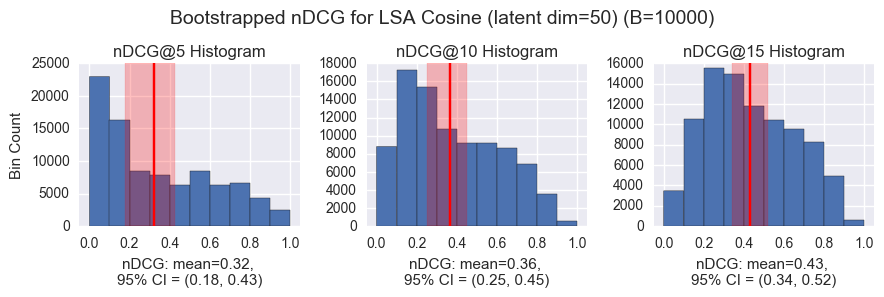

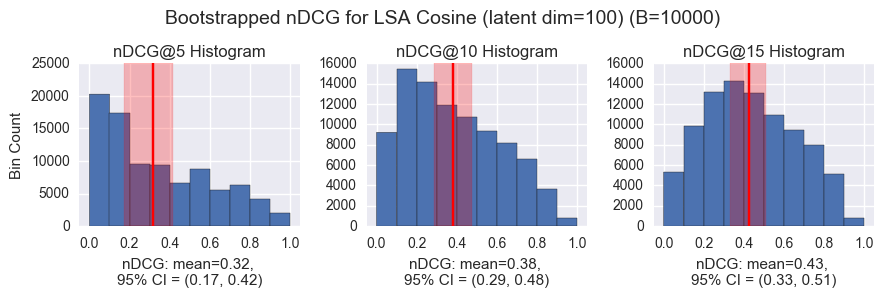

In [28]:
for d in [10,50,100]:
    lsa_model = LSAModel(d)
    print "Training...",
    train_time = lsa_model.fit(all_post_texts)
    print "Took {} hours for {} docs".format(sec2hms(train_time), len(all_post_texts))
    model_name = "LSA Cosine (latent dim={})".format(d)
    results[model_name] = score_model(lsa_model, model_name, B=10000, verbose=0)

### Baseline 4: LDA

**Note:** these results aren't correct because LDA hasn't been fit on the whole corpus yet... it's extremely slow...

In [1]:
class LDAModel(ModelBase):
    def __init__(self, n_topics, **lda_kwds):
        self.tokenizer = TweetTokenizer()
        self.tokenize = self.tokenizer.tokenize
        self.vectorizer = CountVectorizer(min_df=5, stop_words='english', tokenizer=self.tokenize)
        self.lda = LDA(n_topics, learning_method='online',
                       random_state=0, **lda_kwds)
        self.pipeline = Pipeline([('vec', self.vectorizer), ('lda', self.lda)])

NameError: name 'ModelBase' is not defined

 Training... Took 00:00:01 hours for 296240 docs
Training... Took 00:00:01 hours for 296240 docs
Training... Took 00:00:01 hours for 296240 docs


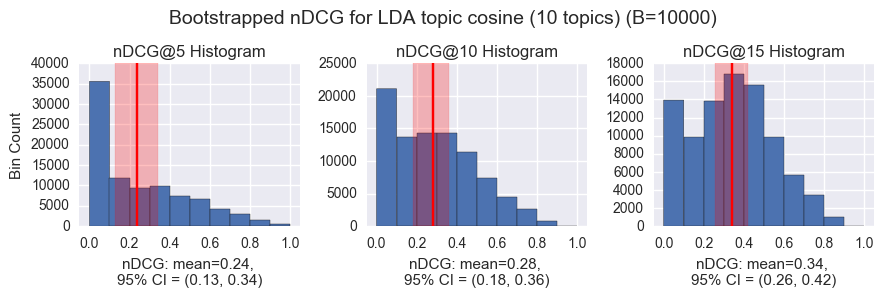

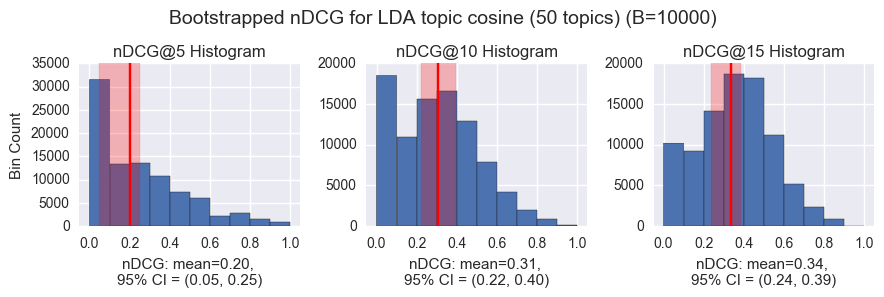

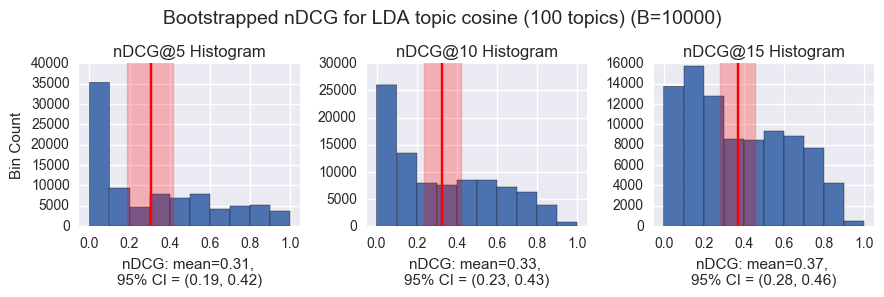

In [52]:
for d in [10,50,100]:
    lda_model = LDAModel(d, n_jobs=-1)
    print "Training...",
    train_time = lda_model.fit(all_post_texts[:100])
    print "Took {} hours for {} docs".format(sec2hms(train_time), len(all_post_texts))
    model_name = "LDA topic cosine ({} topics)".format(d)
    results[model_name] = score_model(lda_model, model_name, B=10000, verbose=0)

### Baseline 5: SF-IDF

In [55]:
class SfIdfModel(ModelBase):
    def __init__(self, window_width=10):
        self.tokenizer = TweetTokenizer()
        
        def sf_transform(doc_string):
            """ Tokenize the input with NLTK, do word sense disambiguation, then do synset transformation. """
            tokens = self.tokenizer.tokenize(doc_string)
            for i, token in enumerate(tokens):
                start = 0 if i-window_width < 0 else i-window_width
                synset = lesk(tokens[start:i+window_width], token)
                if synset:
                    tokens[i] = synset.name()
            return tokens
    
        self.pipeline = TfidfVectorizer(min_df=5, stop_words='english', tokenizer=sf_transform)

In [56]:
sfidf_model = SfIdfModel()
print "Training...",
train_time = sfidf_model.fit(all_post_texts)
print "Took {} hours for {} docs".format(sec2hms(train_time), len(all_post_texts))
model_name = "SF-IDF Cosine"

Training... Took 00:19:22 hours for 296240 docs


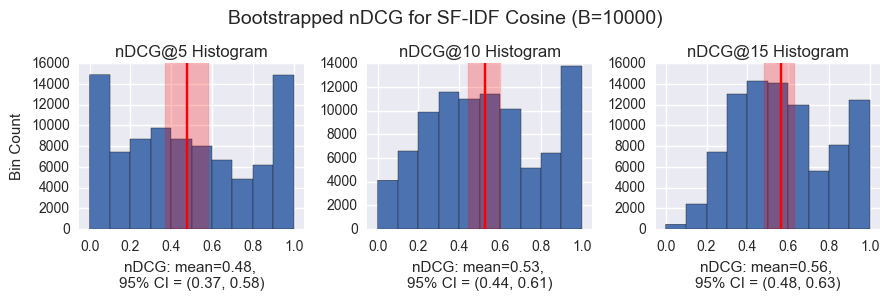

In [57]:
results[model_name] = score_model(sfidf_model, model_name, B=10000, verbose=0)

### Neural Continuous Bag of Words (average of word vectors)

In [90]:
class NeuralCBOWModel(object):
    def __init__(self, composition_func=np.mean):
        self.word2vec = {}
        self.tokenizer = TweetTokenizer()
        self.composition_func = composition_func
        
    def fit(self, training_docs_list, word2vec=None):
        start = time()
        if word2vec:
            self.word2vec = word2vec
        else:
            token_set = { token for doc in training_docs_list 
                      for token in self.tokenizer.tokenize(doc)
                      if token not in stop_vocab}
            for i, line in enumerate(open('glove.840B.300d.txt')):
                split = line.strip().split()
                try:
                    word, vec = split[0], np.array(split[1:], dtype=np.float32)
                except: 
                    continue
                if word not in token_set:
                    continue
                vec /= np.linalg.norm(vec)
                self.word2vec[word] = vec
                if len(self.word2vec) >= len(token_set): break
            # every token in the dataset has a vector
            # print "{}/{} tokens have pretrained vectors".format(len(self.word2vec), len(token_set))
        return time() - start
    
    def doc2vec(self, doc_str):
        tokens = self.tokenizer.tokenize(doc_str)
        doc_matrix = np.vstack([self.word2vec[token] for token in tokens if token in self.word2vec])
        return self.composition_func(doc_matrix, axis=0)
    
    def predict(self, doc1, doc2):
        vec1, vec2 = self.doc2vec(doc1), self.doc2vec(doc2)
        return np.dot(vec1, vec2)#/(np.linalg.norm(vec1)*np.linalg.norm(vec2))

In [83]:
ncbow_model = NeuralCBOWModel()
print "Training...",
train_time = ncbow_model.fit(all_post_texts)
print "Took {} hours for {} docs".format(sec2hms(train_time), len(all_post_texts))
model_name = "Neural Continuous Bag of Words (AVG)"
results[model_name] = score_model(ncbow_model, model_name, B=10000, verbose=0)

Training...

KeyboardInterrupt: 

### Neural CBOW (sum of word vectors):

Training... Took 00:00:00 hours for 296240 docs
k=5 --------------------------------------------------
Discussion 0 ndcg for anchor 0 = 0.28
Discussion 0 ndcg for anchor 25 = 0.73
Discussion 0 ndcg for anchor 5 = 0.15
Discussion 1 ndcg for anchor 0 = 0.54
Discussion 1 ndcg for anchor 11 = 0.58
Discussion 1 ndcg for anchor 21 = 0.35
Discussion 2 ndcg for anchor 0 = 0.68
Discussion 2 ndcg for anchor 8 = 0.63
Discussion 2 ndcg for anchor 7 = 0.68
k=10 --------------------------------------------------
Discussion 0 ndcg for anchor 0 = 0.28
Discussion 0 ndcg for anchor 25 = 0.65
Discussion 0 ndcg for anchor 5 = 0.27
Discussion 1 ndcg for anchor 0 = 0.64
Discussion 1 ndcg for anchor 11 = 0.53
Discussion 1 ndcg for anchor 21 = 0.33
Discussion 2 ndcg for anchor 0 = 0.72
Discussion 2 ndcg for anchor 8 = 0.57
Discussion 2 ndcg for anchor 7 = 0.82
k=15 --------------------------------------------------
Discussion 0 ndcg for anchor 0 = 0.37
Discussion 0 ndcg for anchor 25 = 0.66
Discussion 0 ndcg 

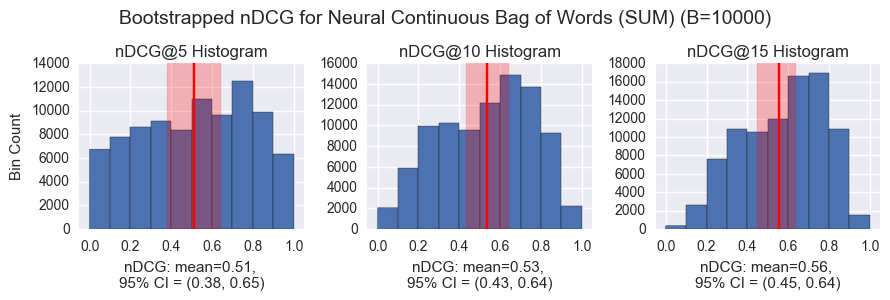

In [186]:
ncbow_model_sum = NeuralCBOWModel(composition_func=np.sum)
print "Training...",
train_time = ncbow_model_sum.fit(all_post_texts, word2vec=ncbow_model.word2vec)
print "Took {} hours for {} docs".format(sec2hms(train_time), len(all_post_texts))
model_name = "Neural Continuous Bag of Words (SUM)"
results[model_name] = score_model(ncbow_model_sum, model_name, B=10000, verbose=1)

### Neural CBOW (TF-IDF weighted sum of word vectors)

In [185]:
class TfIdfNeuralCBOWModel(object):
    def __init__(self):
        self.word2vec = {}
        self.tokenizer = TweetTokenizer()
        self.tokenize = self.tokenizer.tokenize
        self.tfidf = TfidfVectorizer(min_df=5, stop_words='english', tokenizer=self.tokenize)
        
    def fit(self, training_docs_list):
        start = time()
        self.tfidf.fit(training_docs_list)
        token_set = { token for doc in training_docs_list 
                      for token in self.tokenize(doc)
                      if token not in stop_vocab }
        for i, line in enumerate(open('glove.840B.300d.txt')):
            split = line.strip().split()
            try:
                word, vec = split[0], np.array(split[1:], dtype=np.float32)
            except: 
                continue
            if word not in token_set:
                continue
            vec /= np.linalg.norm(vec)
            self.word2vec[word] = vec
            if len(self.word2vec) >= len(token_set): break
        self.vocab_set = set(self.word2vec.keys()) & set(self.tfidf.vocabulary_.keys())
        # every token in the dataset has a vector
        # print "{}/{} tokens have pretrained vectors".format(len(self.word2vec), len(token_set))
        return time() - start
    
    def doc2vec(self, doc_str):
        tfidf_vec = self.tfidf.transform([doc_str])
        tokens = [ token for token in self.tokenize(doc_str) if token in self.vocab_set ]
        doc_matrix = np.vstack([self.word2vec[token] for token in tokens])
        matching_weights = np.array([ tfidf_vec[0, self.tfidf.vocabulary_[token]] for token in tokens])
        weighted_doc_vec = (doc_matrix.T * matching_weights).sum(axis=1)
        return weighted_doc_vec
    
    def predict(self, doc1, doc2):
        vec1, vec2 = self.doc2vec(doc1), self.doc2vec(doc2)
        return np.dot(vec1, vec2)

In [184]:
tfidf_ncbow_model = TfIdfNeuralCBOWModel()
print "Training...",
train_time = tfidf_ncbow_model.fit(all_post_texts)
print "Took {} hours for {} docs".format(sec2hms(train_time), len(all_post_texts))
model_name = "Neural Continuous Bag of Words (TF-IDF)"
results[model_name] = score_model(tfidf_ncbow_model, model_name, B=10000, verbose=0)

NameError: name 'TfIdfNeuralCBOWModel' is not defined

### Output the results as a table

In [66]:
def results_table(results):
    print "{name:^50} | nDCG@5 | ndCG@10 | nDCG@15".format(name="Model")
    for name, res in sorted(results.items(), key=lambda x:x[0]):
        print '-'*80
        print "{name:^50} |  {mean1:2.2f}  |   {mean2:2.2f}  |   {mean3:2.2f}  ".format(
            name=name, mean1=res[5]['mean'], mean2=res[10]['mean'],  mean3=res[15]['mean'])
        
results_table(results)

                      Model                        | nDCG@5 | ndCG@10 | nDCG@15
--------------------------------------------------------------------------------
       Neural Continuous Bag of Words (SUM)        |  0.51  |   0.53  |   0.56  
--------------------------------------------------------------------------------
                 Random Baseline                   |  0.22  |   0.21  |   0.35  
--------------------------------------------------------------------------------
                  SF-IDF Cosine                    |  0.48  |   0.53  |   0.56  
--------------------------------------------------------------------------------
                  TF-IDF Cosine                    |  0.49  |   0.59  |   0.62  


### Look at who fails where

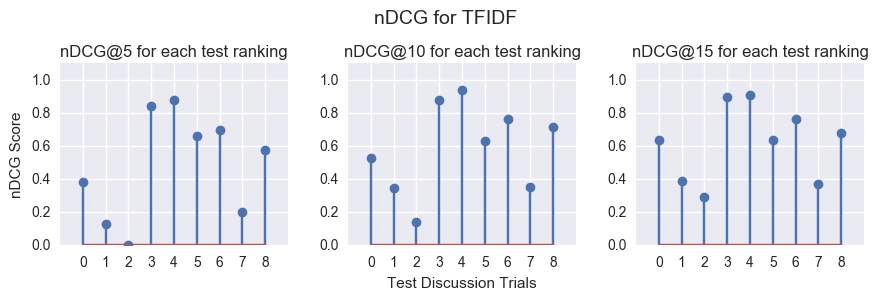

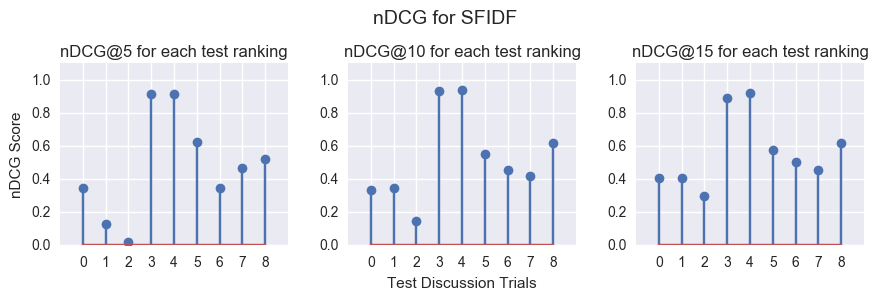

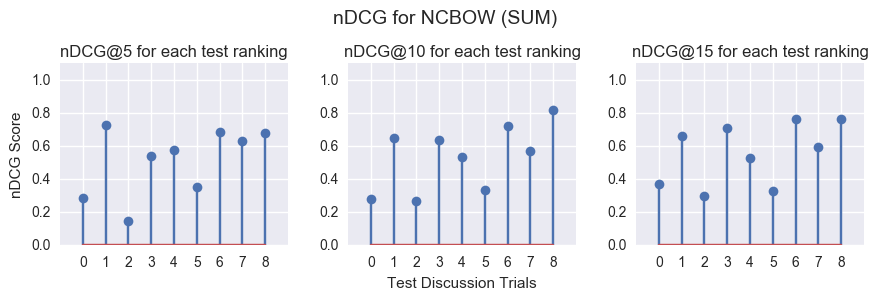

In [205]:
tfidf_ndcgs = error_analyze(tfidf_model, "TFIDF")
sfidf_ndcgs = error_analyze(sfidf_model, "SFIDF")
ncbow_sum_ndcgs = error_analyze(ncbow_model_sum, 'NCBOW (SUM)')

Looking at the errors, it appears that TFIDF and SFIDF do almost identical things, whereas the Neural CBOW has very different strengths. Let's dig into why ncbow did better on some and tfidf did better on others.

As a first pass (before looking at raw data) is there:
* a difference in the post lengths
* number of posts in discussion
* very large overlap of words in the posts in the discissions

In [238]:
# first convert the test data to a raw [ [anchor tokens, [(candidate tokens, score)]] ]
unraveled_tests = []
for did, discussion in enumerate(test_data):
    anchor_ids = { triple[0] for triple in discussion['relevance_scores'] }
    for aid in anchor_ids:
        print did, aid # visually make sure testset order is the same
        anchor_tokens = discussion['posts'][aid]['text']
        candidates = []
        for aid, cid, score in [triple for triple in discussion['relevance_scores'] if triple[0]==aid]:
            candidates.append((discussion['posts'][cid]['text'], score))
        unraveled_tests.append((anchor_tokens, candidates))

0 0
0 25
0 5
1 0
1 11
1 21
2 0
2 8
2 7


In [239]:
# # high level analysis per discussion
# fig, axs = plt.subplots(1,3, figsize=(9,3))

# xticks = np.arange(len(tfidf_ndcgs))
# w = .1

# axs[0].set_title('nDCG@15')
# axs[0].stem(xticks-w, tfidf_ndcgs, 'r', markerfmt='ro')
# axs[0].stem(xticks+w, nbow_sum_ndcgs)

# axs[1].set_title('Anchor doc length')
# a = [len(d[0]) for d in tokenized_tests]
# axs[1].stem(xticks, a, 'g', markerfmt='go')

# # for i, (test, tfidf_ndcg, ncbow_ndcg) in enumerate(zip(tokenized_tests, tfidf_ndcgs, nbow_sum_ndcgs)):
# #     print i+1, '-'*50
# #     print 'TFIDF:{0:2.2f} NCBOW:{1:2.2f}'.format(tfidf_ndcg[0], ncbow_ndcg[0])
# #     print "Anchor Doc Len: {}".format(len(test[0]))
# #     lens = [len(doc[0]) for doc in test[1]]
# #     print "Candidate Doc Lens mean:{0:2.2f}, sd:{1:2.2f}, n:{2}".format(np.mean(lens), np.std(lens), len(lens))

This is hard to conclude anything from, there is no easily discernable pattern.

Instead we will do a low level error analysis discplaying the actual top-k data and the nDCGs for train and test

In [281]:
from IPython.core.display import HTML
from cgi import escape

<style>
th {border: 2px solid blue;}
</style>

In [300]:
html = u"""
<head>
    <!--<link type="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/css/bootstrap.min.css">-->
</head>
<body>
    <table>
        {}
    </table>
</body>
"""

table = u""""""
k = 5
T = 5 # max display len of doc
tokenize = TweetTokenizer().tokenize
def jaccard(tokens1, tokens2):
    s1, s2 = set(tokens1), set(tokens2)
    return len(s1 & s2)/float(len(s1 | s2))

for i, test in enumerate(unraveled_tests):
    anchor_tokens = tokenize(test[0])
    # make header and anchor row
    table += u'''<tr>
    <th colspan="3">Discussion {0} nDCG@{1} :: TFIDF: {2:2.2f}   |   NCBOW: {3:.2f}</th>
    <!--
    <th>TFIDF Rank</th>
    <th>NCBOW Rank</th>
    -->
    <th>TFIDF Choices</th>
    <th>TFIDF Gold Score</th>
    <th>NCBOW Choices</th>
    <th>NCBOW Gold Score</th>'''.format(
        i, k, tfidf_ndcgs[k][i][0], ncbow_sum_ndcgs[k][i][0])
    table += u"""<tr></tr><tr>
        <th>Anchor</th>
        <th>Scores</th>
        <td colspan="5">{}</td>
        </tr>""".format(u" ".join(anchor_tokens))
    
    # show top k gold candidates and the associated scores
    tfidf_scores = np.array([tfidf_model.predict(test[0], cand[0]) for cand in test[1]])
    tfidf_rankmap = np.argsort(-tfidf_scores)#[::-1]
    ncbow_scores = np.array([ncbow_model_sum.predict(test[0], cand[0]) for cand in test[1]])
    ncbow_rankmap = np.argsort(-ncbow_scores)#[::-1]
    for ci, cand in sorted(zip(range(len(test[1])),test[1]), key=lambda x:x[1][1], reverse=True)[:k]:
#         print test[1][tfidf_rankmap[ci]]
        cand_tokens = tokenize(cand[0])
        table += u"""<tr>
            <th>Cand</th>
            <th>{score}</th>
            <td title="{full_gold}">Gold Post (hover over)</td>
            <!--
            <td>{tfidf_rank}</td>
            <td>{ncbow_rank}</td>
            -->
            <td title="{full_tfidf}">TFIDF Choice (hover over)</td>
            <td>{tfidf_gold_score}</td>
            <td title="{full_ncbow}">NCBOW Choice (hover over)</td>
            <td>{ncbow_gold_score}</td>
            </tr>""".format(
            score=cand[1], 
            gold=escape(u" ".join(cand_tokens[:T])), 
            full_gold=escape(u" ".join(cand_tokens)),
            tfidf_rank=tfidf_rankmap[ci]+2,#tfidf_model.predict(test[0], cand[0]),
            ncbow_rank=ncbow_rankmap[ci]+2,#ncbow_model_sum.predict(test[0], cand[0]),
            tfidf_choice=escape(u" ".join(tokenize(test[1][tfidf_rankmap[ci]][0])[:T])),
            ncbow_choice=escape(u" ".join(tokenize(test[1][ncbow_rankmap[ci]][0])[:T])),
            full_tfidf=escape(u" ".join(tokenize(test[1][tfidf_rankmap[ci]][0]))),
            full_ncbow=escape(u" ".join(tokenize(test[1][ncbow_rankmap[ci]][0]))),
            tfidf_gold_score=test[1][tfidf_rankmap[ci]][1],
            ncbow_gold_score=test[1][ncbow_rankmap[ci]][1]
        )
HTML(html.format(table))

In [168]:
class Ensemble():
    """ Take ensemble of model predictions and combine them.  Models must be pretrained"""
    def __init__(self, models):
        self.models = models
        # for normalizing unnormalized predictions
        self.z = lambda x, m, s: (x-m)/s 
        # picks the most confident model as choice (furthest from 0)
        self.comb_func = lambda x: sorted(x, key=lambda y:abs(y), reverse=True)[0]
        
    def calibrate(self, discussions_list, n_samples=1000):
        # learn a model-specific rescaling
        # do this by sampling anchor, candidate pairs from discussions
        # getting the model activations for these
        # then calculating a Z-normalizer for each model
        self.normalizers = []
        pairs = self._sample_pairs(discussions_list, n_samples)
        for model in self.models:
            scores = []
            for pair in pairs:
                try:
                    scores.append(model.predict(*pair))
                except:
                    pass
            self.normalizers.append((np.mean(scores), np.std(scores)))
        
    def _sample_pairs(self, discussions_list, n):
        pairs = []
        for i in range(n):
            discussion = discussions_list[npr.randint(len(discussions_list))]
            # make sure we sample a good discussions
            while len(discussion) < 5:
                discussion = discussions_list[npr.randint(len(discussions_list))]
            ai, ci = npr.choice(range(len(discussion)), 2, replace=False)
            pairs.append((discussion[ai], discussion[ci]))
        return pairs
    
    def predict(self, doc1, doc2):
        scores = [ self.z(model.predict(doc1, doc2), m, s) 
                   for model, (m,s) in zip(self.models, self.normalizers) ]
        
        return self.comb_func(scores)

Calibrating... Done


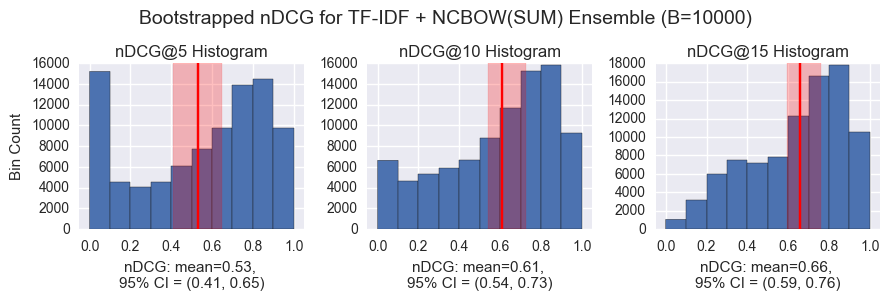

In [169]:
ensemble_model = Ensemble([tfidf_model, ncbow_model_sum])
train_discussions = [ [ post['text'] for post in discussion['posts'] ] for discussion in train_data ]
print "Calibrating...",
ensemble_model.calibrate(train_discussions, 1000)
print "Done"
model_name = "TF-IDF + NCBOW(SUM) Ensemble"
results[model_name] = score_model(ensemble_model, model_name, B=10000, verbose=0)

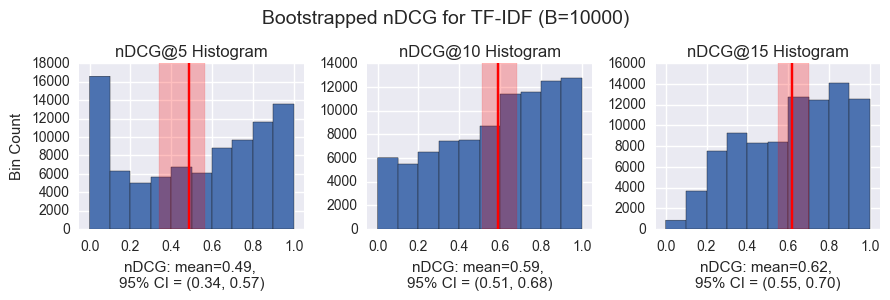

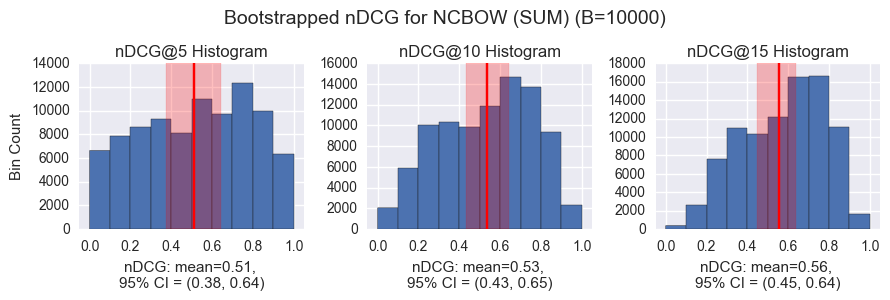

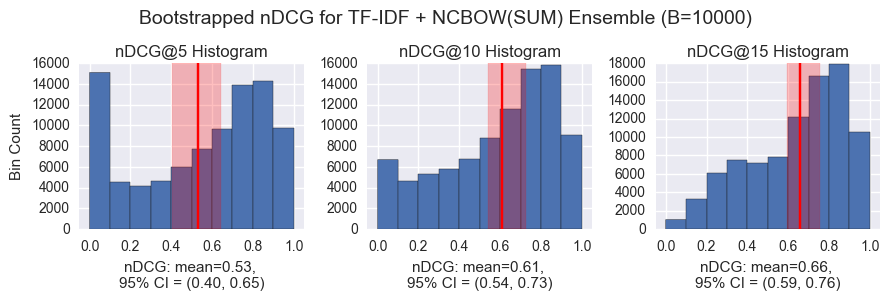

In [172]:
# Now how do the scores and errors stack up when viewed right next to eachother
_ = score_model(tfidf_model, "TF-IDF", B=10000, verbose=0)
_ = score_model(ncbow_model_sum, "NCBOW (SUM)", B=10000, verbose=0)
_ = score_model(ensemble_model, "TF-IDF + NCBOW(SUM) Ensemble", B=10000, verbose=0)

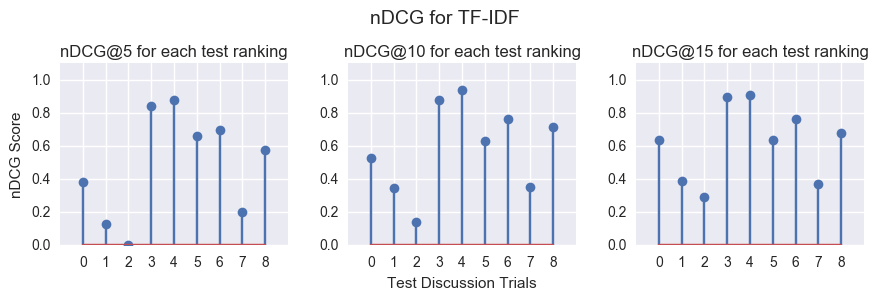

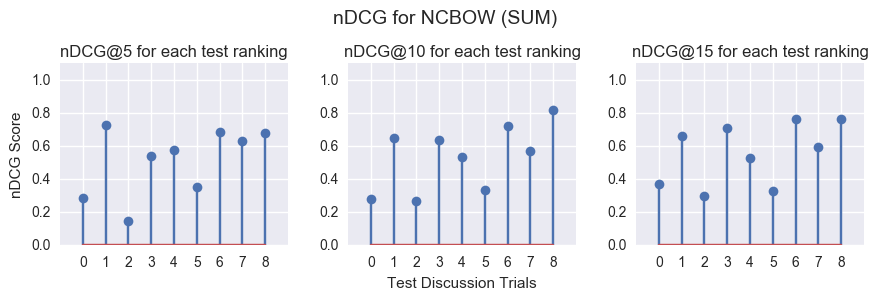

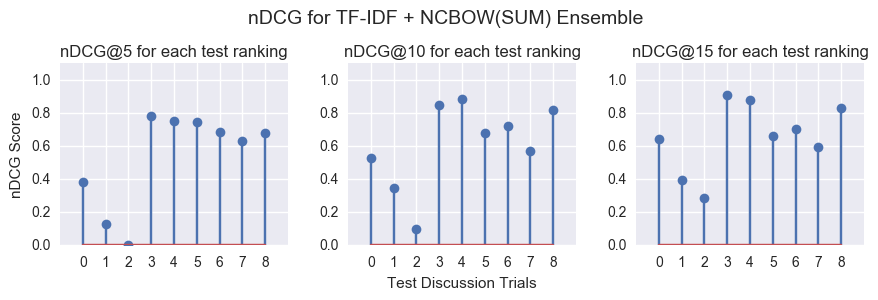

In [178]:
error_analyze(tfidf_model, "TF-IDF")
error_analyze(ncbow_model_sum, "NCBOW (SUM)")
error_analyze(ensemble_model, "TF-IDF + NCBOW(SUM) Ensemble")

In [ ]:
results_table(results)

### Treat a document as a finite gaussian mixture. Infer with mean field.

In [450]:
class DocGMM(object):
    def __init__(self, min_words=5, allow_singular=True, **gmm_kwds):
        self.word2vec = {}
        self.tokenizer = TweetTokenizer()
        # always use spherical covariance
#         gmm_kwds['covariance_type'] = 'spherical'
        self.doc1_gmm = GMM(**gmm_kwds)
        self.doc2_gmm = GMM(**gmm_kwds)
        self.max_n_components = self.doc1_gmm.n_components
        self.min_words = min_words
        self.allow_singular = allow_singular
        
    def fit(self, training_docs_list, word2vec=None, stop_vocab={}):
        start = time()
        if word2vec: 
            self.word2vec = word2vec
        else:
            token_set = { token for doc in training_docs_list 
                      for token in self.tokenize(doc)
                      if token not in stop_vocab }
            for i, line in enumerate(open('glove.840B.300d.txt')):
                split = line.strip().split()
                try:
                    word, vec = split[0], np.array(split[1:], dtype=np.float32)
                except: 
                    continue
                if word not in token_set:
                    continue
                vec /= np.linalg.norm(vec)
                self.word2vec[word] = vec
                if len(self.word2vec) >= len(token_set): break
                    
        # add a special zero vector for padding docs
#         self.word2vec[self.pad] = np.zeros_like(self.word2vec.values()[0])
        self.vocab_set = set(self.word2vec.keys())
        self.stop_vocab = stop_vocab
        # every token in the dataset has a vector
        # print "{}/{} tokens have pretrained vectors".format(len(self.word2vec), len(token_set))
        return time() - start
    
    def print_clustering(self, tokens, clusters):
        groups = {}
        for t,c in zip(tokens, clusters):
            if c in groups:
                groups[c].append(t)
            else:
                groups[c] = [t]
        for c, c_tokens in groups.items():
            print c, '::', ", ".join(c_tokens)
    
    def tokenize(self, doc_str):
        tokens = [ token for token in self.tokenizer.tokenize(doc_str) 
                  if token in self.vocab_set and token not in self.stop_vocab ]
        return tokens
    
    def doc_vector(self, tokens):
        return np.vstack([self.word2vec[token] for token in tokens if token in self.vocab_set])

    def sim(self, gmm1, gmm2, kind="kl", n_samples=1e5):
        """ Compute the similarity between two gaussian mixtures.
        
        If kind='kl', then we compute kl(gmm1||gmm2) through a montecarlo estimate.
        Elif kind='elip', then we compute the expected likelihood inner product.
        """
        if kind == 'kl':
            X, _ = gmm1.sample(n_samples)
            log_p_X = gmm1.score_samples(X)
            log_q_X = gmm2.score_samples(X)
#             print log_p_X.shape, log_q_X.shape
            return log_q_X.mean() - log_p_X.mean() # negative KL
        
        elif kind == 'elip':
            # do log sum exp trick for stability
            log_densities = np.zeros((len(gmm1.means_), len(gmm2.means_)))
            for i, (mean1, covar1) in enumerate(zip(gmm1.means_, gmm1.covariances_)):
                for j, (mean2, covar2) in enumerate(zip(gmm2.means_, gmm2.covariances_)):
                    dist = st.multivariate_normal(mean=(mean1-mean2), cov=(covar1+covar2), allow_singular=self.allow_singular)
                    log_densities[i,j] = dist.logpdf(np.zeros_like(mean1))
            max_log_density = np.max(log_densities)
            log_densities -= max_log_density

            # calculate the actual value
            cumsum = 0.
            for i, pi1 in enumerate(gmm1.weights_):
                for j, pi2 in enumerate(gmm2.weights_):
                    cumsum += pi1 * pi2 * np.exp(log_densities[i,j])
            return max_log_density + np.log(cumsum)
        else:
            raise ValueError, "Unknown time of GMM distance"
    
    def predict(self, doc1, doc2, rescale=1., verbose=0, **sim_kwds):
        tokens1 = self.tokenize(doc1)
        tokens2 = self.tokenize(doc2)
        
        # set the gmms to not have more components than tokens
        # if there are less than `min_words` tokens in a doc, return a similarity of -inf
        # these docs are too short to analyze, and it's safe to assume they aren't relevant either
        if len(tokens1) < self.min_words:
            return -1e10
        elif len(tokens1) < self.max_n_components:
            self.doc1_gmm.set_params(n_components=len(tokens1))
        else:
            self.doc1_gmm.set_params(n_components=self.max_n_components)
        if len(tokens2) < self.min_words:
            return -1e10
        elif len(tokens2) < self.max_n_components:
            self.doc2_gmm.set_params(n_components=len(tokens2))
        else:
            self.doc2_gmm.set_params(n_components=self.max_n_components)
            
        # convert nondegenerate docs to bag of embeddings
        cbow1 = rescale*self.doc_vector(tokens1)
        cbow2 = rescale*self.doc_vector(tokens2)
            
#         cbow1, cbow2 = rescale*self.doc_vectorizer(doc1), rescale*self.doc_vectorizer(doc2)
#         print cbow1.shape, cbow2.shape
#         print cbow1
        
        try:
            self.doc1_gmm.fit(cbow1)
        except ValueError as e:
            print "Offending Doc: ", tokens1
            raise e
        clusters1 = self.doc1_gmm.predict(cbow1)
        if verbose > 1:
            print 'Doc 1', '*'*50
            print 'Text:\n', doc1
            print
            self.print_clustering(tokens1, clusters1)
            print 'Cluster proportions: ', self.doc1_gmm.weights_
            
        try:
            self.doc2_gmm.fit(cbow2)
        except ValueError as e:
            print "Offending Doc: ", tokens2
            raise e
        clusters2 = self.doc2_gmm.predict(cbow2)
        if verbose > 1:
            print 'Doc 2', '*'*50
            print 'Text:\n', doc2
            print
            self.print_clustering(tokens2, clusters2)
            print 'Cluster proportions: ', self.doc2_gmm.weights_
            print 
        try:
            return self.sim(self.doc1_gmm, self.doc2_gmm, **sim_kwds)
        except Exception as e:
            # Except stuff like singlarity errors and just punt
            print e
            return -1e10


In [451]:
w2v = gmm_model.word2vec

In [461]:
gmm_model = DocGMM(n_components=5, 
                   reg_covar=1e-1, 
                   weight_concentration_prior=1., 
                   covariance_type='full',
                   n_init=1,
                   verbose=0)
print "Training...",
useless_vocab = stop_vocab | { c for c in punctuation }
train_time = gmm_model.fit(all_post_texts, word2vec=w2v, stop_vocab=useless_vocab)#ncbow_model.word2vec)
print "Took {} hours for {} docs".format(sec2hms(train_time), len(all_post_texts))
model_name = "Gaussian Mixture Expected Likelihood Inner Product"

Training... Took 00:00:00 hours for 296240 docs


In [462]:
for i in range(0,20,2):
    s, o = i, i+1
    sim = gmm_model.predict(all_post_texts[s],all_post_texts[s+o], rescale=1, verbose=2, kind='kl')
    print 'Similarity score: {0:2.2f}'.format(sim)
    print '='*80

Doc 1 **************************************************
Text:
The Big Blue Test is coming up soon. Have you checked it out? You can find the latest updates at http://bigbluetest.org/. We are looking for some programming help for the Big Blue Test app. Do you have experience with any of the following? HTML CSS Javascript node.js AngularJS Express Jade  Do you have the time and energy to work on a short term project? It needs to be done before the October 15th launch of this year's Big Blue Test.  If you answered "YES!" then please contact Dave Cornejo at dave@dogwood.com. Thanks! The Big Blue Test is coming up soon. Have you checked it out? You can find the latest updates at http://bigbluetest.org/. The Big Blue Test is coming up soon. Have you checked it out? You can find the latest updates at http://bigbluetest.org/. http://bigbluetest.org/  We are looking for some programming help for the Big Blue Test app. We are looking for some programming help for the Big Blue Test app. We are l

In [463]:
def bootstrap_score(trues, preds, scoring_func, B=10000, **scoring_func_kwds):
    """ Compute a bootstrapped estimate of the model score. 
    
    An intuitive and practical guide to bootstrap estimation:
    https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf
    """
    samples = []
    idxs = np.arange(len(trues))
    for i in range(B):
        sample = npr.choice(idxs, len(idxs))
        samples.append(scoring_func(trues[sample], preds[sample], **scoring_func_kwds))
    return samples

def score_model_at_k(model, k, data=test_data, 
                     verbose=0, B=10000,
                     refit_per_discussion=False):
    """ Take some model, get relevance scores from it on test data, return nDCG at specified k.
    
    TODO: Make this more efficient by doing predictions and scoring all ks simultaneously. Will be k times faster"""
    if verbose: print 'k={}'.format(k), '-'*50
    all_scores = []
    for i, discussion in enumerate(data):
        if refit_per_discussion:
            model.fit([post['text'] for post in discussion['posts']])
        scores = {}
        for anchor_id, candidate_id, true_score in discussion['relevance_scores']:
            # organize true relevance scores grouped by anchor post
            if anchor_id in scores:
                scores[anchor_id]['trues'].append(true_score)
            else:
                scores[anchor_id] = {'trues':[true_score], 'preds':[]}
            
            pred_score = model.predict(discussion['posts'][anchor_id]['text'],
                                       discussion['posts'][candidate_id]['text'], verbose=verbose)
#             print pred_score
            scores[anchor_id]['preds'].append(pred_score)
            if verbose > 1: print true_score, pred_score
        for anchor_id in scores:
            trues = np.array(scores[anchor_id]['trues'])
            preds = np.array(scores[anchor_id]['preds'])
            ndcg = ndcg_score(trues, preds, k=k)
            if B:
                ndcg_bootstrapped = bootstrap_score(trues, preds, ndcg_score, B=B, k=k)
                # the true ndcg will just be the first one, all the rest are resampled
                all_scores.append([ndcg] + ndcg_bootstrapped)
            else:
                all_scores.append(ndcg)
            if verbose: print 'Discussion {0} ndcg for anchor {1} = {ndcg:2.2f}'.format(i, anchor_id,
                                                                                        ndcg=ndcg)
    return all_scores
        
def score_model(model, model_name, ks=[5,10,15], B=10000, **kwds):
    """ Run the entire experiment for some pretrained model. """
    results = {}
    fig, axs = plt.subplots(1,len(ks),figsize=(3*len(ks),3))
    for i, k in enumerate(ks):
        # do scoring
        all_scores = score_model_at_k(model, k, B=B, **kwds)
        ndcgs = [ scores[0] for scores in all_scores]
        ndcgs_resampled = zip(*[bootstrap_sample[1:] for bootstrap_sample in all_scores])
        ndcg_mean, resampled_means = np.mean(ndcgs), [np.mean(sample) for sample in ndcgs_resampled]
        diffs = [resampled_mean - ndcg_mean for resampled_mean in resampled_means]
#         variance = 
        alpha = .025
        ci_bottom = ndcg_mean - np.percentile(diffs, 100.*(1-alpha))
        ci_top = ndcg_mean - np.percentile(diffs, 100.*alpha)
        results[k] = {
            'mean':ndcg_mean,
            'ci':(ci_bottom, ci_top),
            'scores':[ score for scores in all_scores for score in scores ]
        }
#         print "nDCG@{k}: mean={mean:2.2f}, std={std:2.2f}".format(k=k, mean=mean, std=std)

        # make nice plots
        flat_ndcgs = [ ndcg for sample in all_scores for ndcg in sample ]
        axs[i].hist(flat_ndcgs, bins=.1*np.arange(11))
        axs[i].axvline(ndcg_mean, color='red')
        axs[i].axvspan(ci_bottom, ci_top, alpha=.25, color='red')
        axs[i].set_xlim((-.05, 1.05))
        axs[i].set_title("nDCG@{k} Histogram".format(k=k))
        axs[i].set_xlabel("nDCG: mean={mean:2.2f}, \n95% CI = ({ci_bottom:2.2f}, {ci_top:2.2f})".format(
                mean=ndcg_mean, ci_bottom=ci_bottom, ci_top=ci_top))
        if i == 0:
            axs[i].set_ylabel("Bin Count")
    fig.suptitle("Bootstrapped nDCG for {} (B={})".format(model_name, B), fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.8)
    results['fig'] = fig
    return results

k=5 --------------------------------------------------
Discussion 0 ndcg for anchor 0 = 0.18
Discussion 0 ndcg for anchor 25 = 0.30
Discussion 0 ndcg for anchor 5 = 0.02
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a value too large for dtype('float64').
Input contains NaN, infinity or a valu

KeyboardInterrupt: 

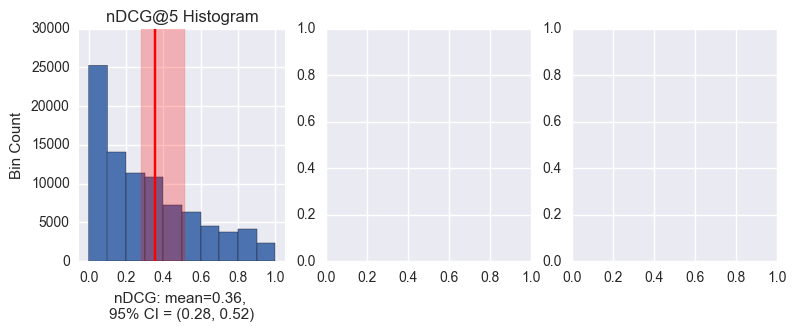

In [464]:
results[model_name] = score_model(gmm_model, model_name, B=10000, verbose=1)

KeyboardInterrupt: 

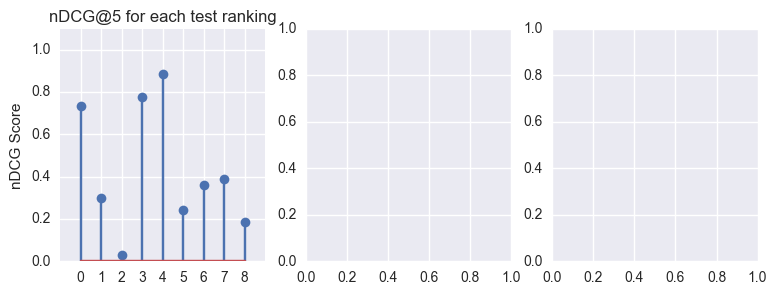

In [419]:
error_analyze(gmm_model, model_name)

### Treating Doc as inifinite gaussian mixture -- could have been very cool but failing due to numerical issues

In [4]:
# class GibbsDPGMM():
#     def fit(self, X, T=500, alpha=1.):
#         # inits
#         X = X[:,:10].astype(np.double)
#         N, d = X.shape
#         # print X.shape
#         a = d
#         c = .1
#         m = np.mean(X, axis=0)
#         # break covariance singularity with small noise
#         # R = npr.multivariate_normal(np.zeros(d), 10.*np.eye(d), size=(N))
#         B = c * d * (np.cov(X.T))#+R.T))
#         cs = [0]*N
#         ns = [len([ci for ci in cs if ci == i]) for i in range(max(cs)+1)]
#         try:
#             sigmas = [st.wishart.rvs(a, B)]
#         except:
#             # because sometimes there are repeated observations, (aka the same word multiple times in a document)
#             # B is not positive definite, but is positive semidefinite
#             # so if that happens, make it postive definite by doing eigen decomp
#             # and overriding nonpositive ones, then reconstruct the covariance matrix
#             w, V = np.linalg.eig(B)
#             print np.all(w > 0.0)
#             w[w <= 1e-5] = 1e-5
#             print w.shape
#             print np.all(w > 0.0)
#             B = np.dot(np.dot(V, w*np.eye(len(w))), V.T)
#             sigmas = [st.wishart.rvs(a, B)]
#         mus = [st.multivariate_normal.rvs(m, np.linalg.inv(c * sigmas[0]))]
#         p = lambda x, mu, sigma: st.multivariate_normal.pdf(x, mu, sigma)
#         self.cluster_sizes = {i:[] for i in range(6)}
#         self.ks = []
        
#         # setup to calculate marginals
#         prefix = (c/(np.pi*(c+1)))**(d/2.)
#         gam_ratio = np.exp(np.sum([sp.gammaln(.5*(a-j)+1) - sp.gammaln(.5*(a-j+1)) for j in range(d)]))
#         denom = np.linalg.det(B)**(-a/2.)
#         coef = prefix * gam_ratio / denom
#         marginal = lambda x: coef * np.linalg.det(B+(c/(1+c))*np.outer(x-m, x-m))**(-.5*(a+1))
        
#         # setup to sample mu and sigma given xs in cluster
#         def sample_theta(xs):
#             s = xs.shape[0]
#             xbar = np.mean(xs, axis=0)
#             aprime = a + s
#             Bprime = B
#             Bprime += np.sum([np.outer(xi-xbar, xi-xbar) for xi in xs])
#             Bprime += (s/(a*s+1))*np.outer(xbar-m, xbar-m)
#             sigma = st.wishart.rvs(aprime, Bprime)
#             cprime = c + s
#             mprime = (c*m + np.sum(xs, axis=0))/(s+c)
#             mu = st.multivariate_normal.rvs(mprime, np.linalg.inv(cprime * sigma))
#             return mu, sigma
            
#         # run the gibbs sampler
#         for t in range(T):
#             # sample cluster assignments
#             for i, xi in enumerate(X):
#                 # 1(a) calculate current cluster scores
#                 ns[cs[i]] -= 1
                
#                 # check if we are destroying a cluster
#                 if ns[cs[i]] == 0:
#                     # if we are, then forget the params of this cluster
#                     ci = cs[i]
#                     ns = [ n for j, n in enumerate(ns) if j != ci ]
#                     mus = [ mu for j, mu in enumerate(mus) if j != ci ]
#                     sigmas = [ sigma for j, sigma in enumerate(sigmas) if j != ci ]
#                     # and drop the index of all clusters above it by 1
#                     cs = [ cj-1 if cj > ci else cj for cj in cs ]
                    
#                 phis = [ p(xi, mus[j], sigmas[j])*ns[j]/(N+alpha-1) 
#                          for j in range(len(ns)) if ns[j] > 0 ]
                
#                 # 1(b) calculate new cluster score
#                 phis.append(marginal(xi)*alpha/(alpha+N-1))
                
#                 # 1(c) normalize and sample cluster assignment
#                 Z = np.sum(phis)
#                 phis = np.array(phis)/Z
#                 ci = npr.choice(range(len(phis)), size=1, p=phis)[0]
#                 cs[i] = ci
                
#                 # check if we are creating a cluster
#                 if ci == (len(phis)-1):
#                     # if we are, sample new params
#                     mu, sigma = sample_theta(xi)
#                     mus.append(mu)
#                     sigmas.append(sigma)
#                     ns.append(0)
                
#                 # (re)increment the count
#                 ns[cs[i]] += 1
            
#             # sample cluster params
#             k = len(set(cs))
#             self.ks.append(k)
#             print "\rT={}, K={}".format(t,k),
#             for i in range(k):
#                 xs = X[np.array(cs) == i]
#                 mu, sigma = sample_theta(xs)
#                 mus[i] = mu
#                 sigmas[i] = sigma
                
#             # check out the cluster sizes
#             for i, (_, v) in enumerate(Counter(cs).most_common(6)):
#                 self.cluster_sizes[i].append(v)
#             while i < 5:
#                 i += 1
#                 self.cluster_sizes[i].append(0)
#         self.mus = mus
#         self.sigmas = sigmas

In [175]:
# model = DocGMM(.1)
# model.fit(all_post_texts[:5], word2vec=ncbow_model.word2vec)
# model.predict(all_post_texts[0], all_post_texts[1])